In [1]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

PG = yf.download('PG', start = '2016-01-01' , end = '2022-01-01')

[*********************100%%**********************]  1 of 1 completed


In [6]:
PG.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,78.360001,78.500000,77.540001,78.370003,61.459167,11529800
2016-01-05,78.440002,78.959999,78.209999,78.620003,61.655243,8133700
2016-01-06,77.669998,78.290001,77.120003,77.860001,61.059212,9551000
2016-01-07,76.849998,77.599998,76.070000,77.180000,60.525936,11973900
2016-01-08,77.360001,77.480003,75.669998,75.970001,59.577038,9676400


# Simple rate of return

In [4]:
PG['Simple_Return'] = (PG['Adj Close'] / PG['Adj Close'].shift(1) ) - 1
PG['Simple_Return']

Date
2016-01-04         NaN
2016-01-05    0.003189
2016-01-06   -0.009667
2016-01-07   -0.008734
2016-01-08   -0.015677
                ...   
2021-12-27    0.011680
2021-12-28    0.005371
2021-12-29    0.008290
2021-12-30   -0.008649
2021-12-31    0.004976
Name: Simple_Return, Length: 1511, dtype: float64

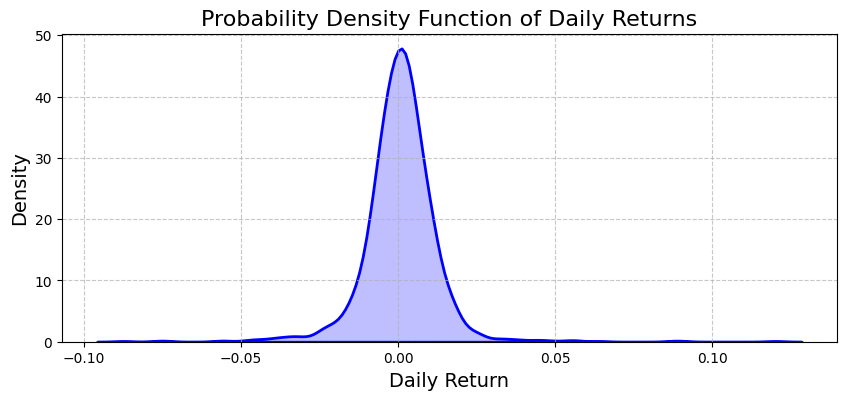

In [5]:
import seaborn as sns

# Plot the PDF of daily returns
plt.figure(figsize=(10, 4))

# Use Seaborn to create a density plot
sns.kdeplot(PG['Simple_Return'].dropna(), fill=True, color='blue', linewidth=2)

# Enhance the plot
plt.title('Probability Density Function of Daily Returns', fontsize=16)
plt.xlabel('Daily Return', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

# Detecting Outlier

# Method 1: Visual Inspection with Z-score Method

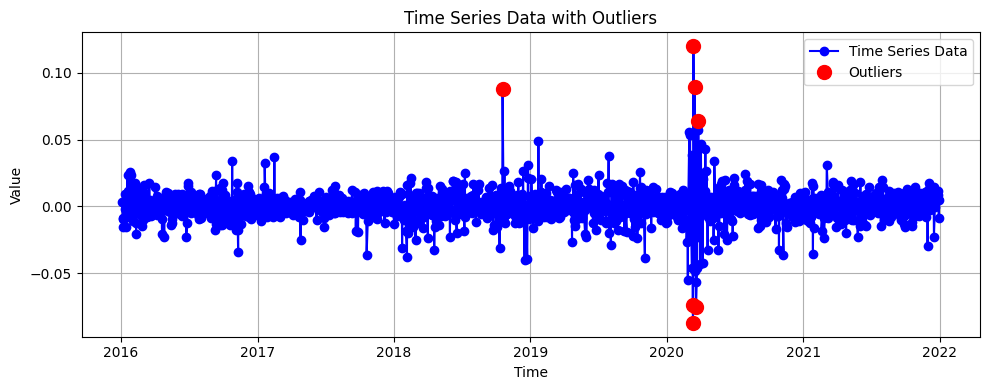

In [6]:
# Introduce an outlier
from scipy.stats import zscore
plt.figure(figsize=(10, 4))
plt.plot(PG.index[1:], PG['Simple_Return'][1:], marker='o', linestyle='-', color='b', label='Time Series Data')

# Calculate Z-score
z_scores = zscore(PG['Simple_Return'][1:])

# Define threshold for outliers (Z-score > 3.0)
outlier_threshold = 5.0
outliers = np.abs(z_scores) > outlier_threshold

# Highlight outliers
plt.plot(PG.index[1:][outliers], PG['Simple_Return'][1:][outliers], 'ro', markersize=10, label='Outliers')

plt.title('Time Series Data with Outliers')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Method 2: Visual Inspection with Model Residual

C:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


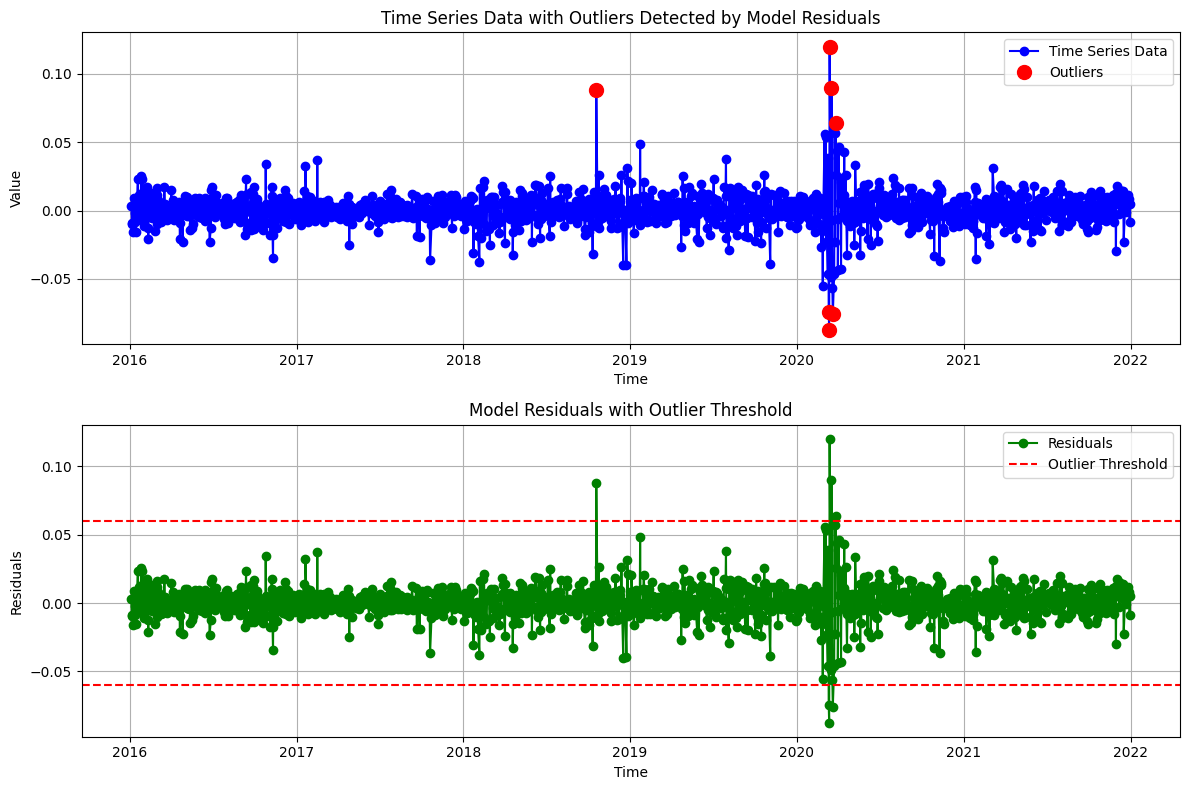

In [7]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model (example: ARIMA(1,0,0))
model = ARIMA(PG['Simple_Return'][1:], order=(1, 0, 0))
model_fit = model.fit()

# Get residuals
residuals = model_fit.resid

# Calculate outlier threshold (e.g., 3 standard deviations)
outlier_threshold = 5.0 * np.std(residuals)

# Identify outliers based on residuals
outliers = np.abs(residuals) > outlier_threshold

# Plot time series data and residuals
plt.figure(figsize=(12, 8))

# Plot time series data
plt.subplot(2, 1, 1)
plt.plot(PG.index[1:], PG['Simple_Return'][1:], marker='o', linestyle='-', color='b', label='Time Series Data')
plt.plot(PG.index[1:][outliers], PG['Simple_Return'][1:][outliers], 'ro', markersize=10, label='Outliers')
plt.title('Time Series Data with Outliers Detected by Model Residuals')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Plot residuals
plt.subplot(2, 1, 2)
plt.plot(PG.index[1:], PG['Simple_Return'][1:], marker='o', linestyle='-', color='g', label='Residuals')
plt.axhline(y=outlier_threshold, color='r', linestyle='--', label='Outlier Threshold')
plt.axhline(y=-outlier_threshold, color='r', linestyle='--')
plt.title('Model Residuals with Outlier Threshold')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Method 3: Visual Inspection with Rolling Statistics

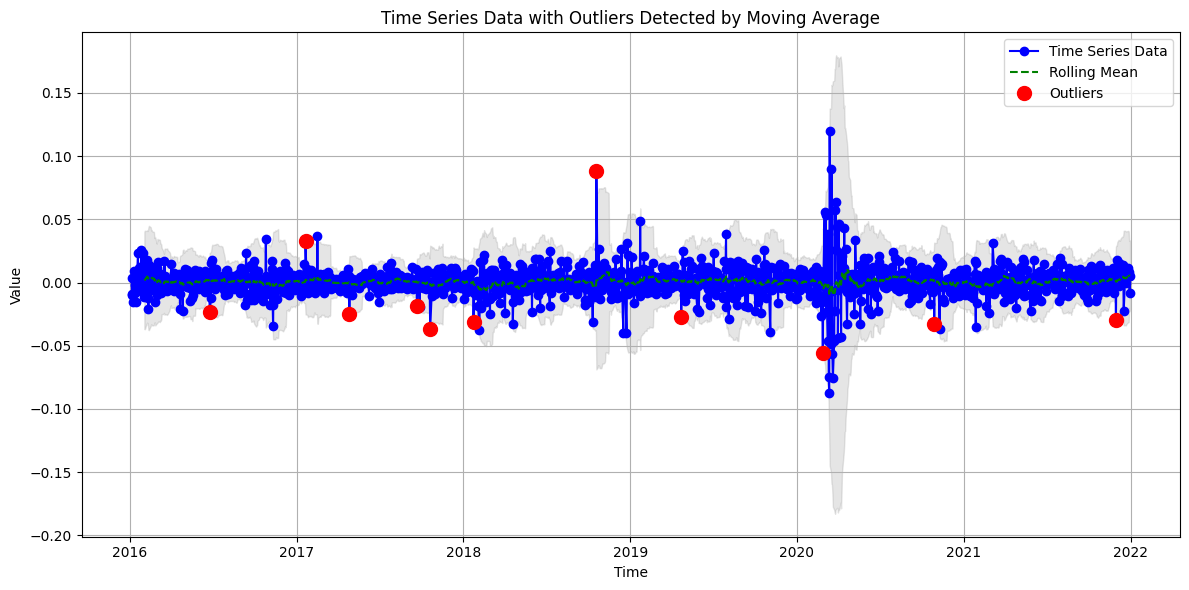

In [8]:
window_size = 20  # Window size for rolling statistics
rolling_mean = PG['Simple_Return'][1:].rolling(window=window_size).mean()
rolling_std = PG['Simple_Return'][1:].rolling(window=window_size).std()

# Define outlier threshold (e.g., 3 standard deviations from rolling mean)
outlier_threshold = 3.0 * rolling_std

# Identify outliers based on rolling statistics
outliers = np.abs(PG['Simple_Return'][1:] - rolling_mean) > outlier_threshold

# Plot time series data and rolling statistics
plt.figure(figsize=(12, 6))

# Plot time series data
plt.plot(PG.index[1:], PG['Simple_Return'][1:], marker='o', linestyle='-', color='b', label='Time Series Data')

# Plot rolling mean and outliers
plt.plot(rolling_mean.index, rolling_mean, linestyle='--', color='g', label='Rolling Mean')
plt.plot(PG.index[1:][outliers], PG['Simple_Return'][1:][outliers], 'ro', markersize=10, label='Outliers')

# Fill between upper and lower bounds of outlier threshold for visualization
plt.fill_between(PG.index[1:], rolling_mean - outlier_threshold, rolling_mean + outlier_threshold, color='gray', alpha=0.2)

plt.title('Time Series Data with Outliers Detected by Moving Average')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Imputing outlier 

# Medhod 1: impute_with_median

In [9]:
def impute_with_median(series, threshold=3):
    """
    Impute outliers in a pandas Series by replacing them with the median of the non-outlier values.

    Parameters:
    series (pd.Series): The input time series data.
    threshold (float): Number of standard deviations from the mean to define outliers.

    Returns:
    pd.Series: Time series with outliers replaced by the median.
    """
    mean = series.mean()
    std_dev = series.std()
    
    # Define the upper and lower limits based on standard deviation
    upper_limit = mean + threshold * std_dev
    lower_limit = mean - threshold * std_dev

    # Identify outliers
    is_outlier = (series > upper_limit) | (series < lower_limit)
    
    # Replace outliers with the median of the non-outlier values
    median_value = series[~is_outlier].median()
    series_imputed = series.copy()
    series_imputed[is_outlier] = median_value
    
    return series_imputed

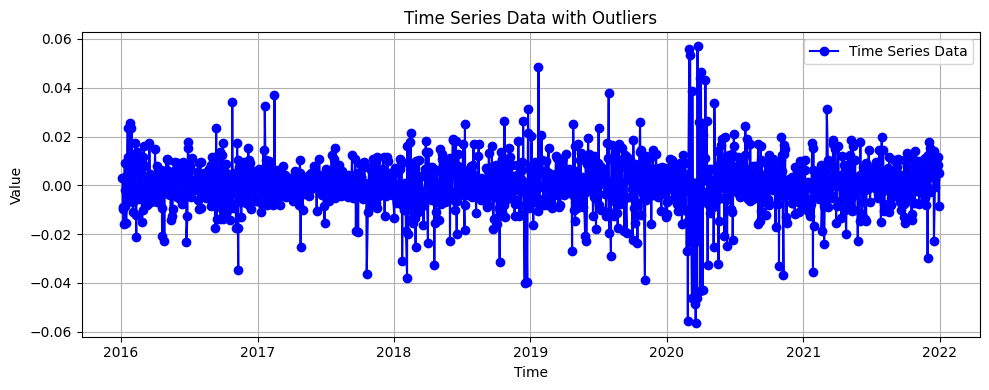

In [10]:
series_imputed = impute_with_median(PG['Simple_Return'][1:], threshold=5)

plt.figure(figsize=(10, 4))
plt.plot(PG.index[1:], series_imputed, marker='o', linestyle='-', color='b', label='Time Series Data')
plt.title('Time Series Data with Outliers')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Method 2: impute_with_limits

In [11]:
def impute_with_limits(series, threshold=3):
    """
    Impute outliers in a pandas Series by replacing them with the upper or lower limit.

    Parameters:
    series (pd.Series): The input time series data.
    threshold (float): Number of standard deviations from the mean to define outliers.

    Returns:
    pd.Series: Time series with outliers replaced by upper or lower limits.
    """
    mean = series.mean()
    std_dev = series.std()
    
    # Define the upper and lower limits based on standard deviation
    upper_limit = mean + threshold * std_dev
    lower_limit = mean - threshold * std_dev

    # Identify outliers
    is_upper_outlier = series > upper_limit
    is_lower_outlier = series < lower_limit
    
    # Replace outliers with the respective limit
    series_imputed = series.copy()
    series_imputed[is_upper_outlier] = upper_limit
    series_imputed[is_lower_outlier] = lower_limit
    
    return series_imputed

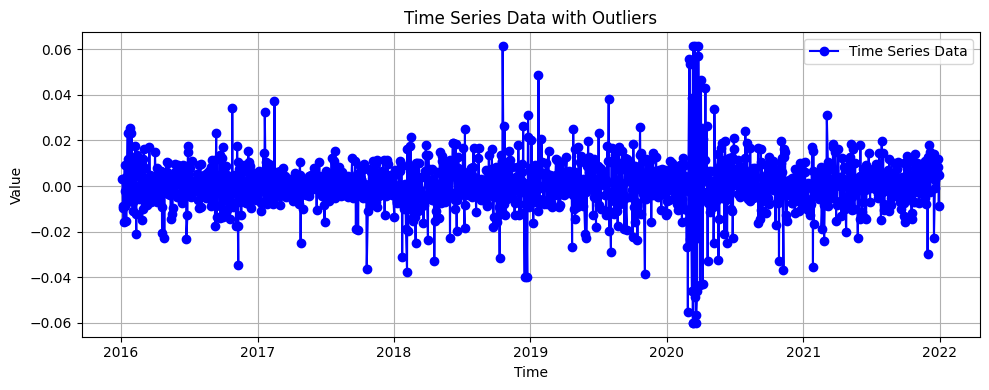

In [12]:
series_imputed = impute_with_limits(PG['Simple_Return'][1:], threshold=5)

plt.figure(figsize=(10, 4))
plt.plot(PG.index[1:], series_imputed, marker='o', linestyle='-', color='b', label='Time Series Data')
plt.title('Time Series Data with Outliers')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Applying various models for forcasting

In [13]:
def acf_plot(series,nlags = 40):
    import statsmodels.api as sm

    # Compute autocorrelation
    acf = sm.tsa.acf(series, fft=True, nlags = nlags)  # Adjust number of lags as needed
    
    # Compute 95% confidence interval
    confint = 1.96 / np.sqrt(len(series))  # For 95% CI
    
    # Define lags
    lags = np.arange(len(acf))
    
    # Plot the autocorrelation function with 95% confidence intervals
    plt.figure(figsize=(10, 6))
    plt.bar(lags, acf, width=0.5, color='blue', alpha=0.7, label='Autocorrelation')
    
    # Add confidence intervals
    plt.axhline(confint, color='red', linestyle='--', label='95% Confidence Interval')
    plt.axhline(-confint, color='red', linestyle='--')
    
    plt.title('Autocorrelation Function of Daily Returns with 95% Confidence Intervals')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.legend()
    plt.grid(True)
    
    # Limit x-axis to only show positive lags
    plt.xlim(0, len(acf) - 1)
    plt.show()

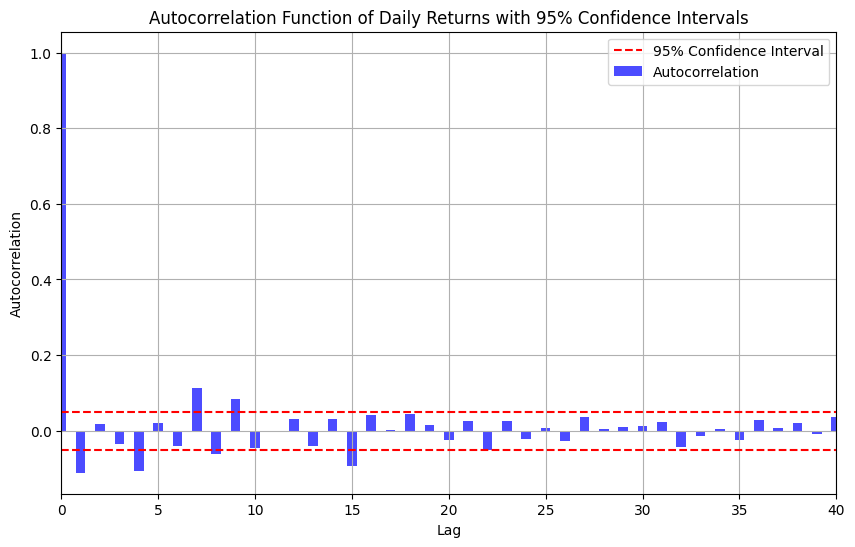

In [14]:
acf_plot(series_imputed,nlags = 40)

# ARIMA model

C:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Program Files\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Progr

Optimal AIC: -9262.041763263565
Optimal Order: (2, 1, 3)
                               SARIMAX Results                                
Dep. Variable:          Simple_Return   No. Observations:                 1510
Model:                 ARIMA(4, 4, 4)   Log Likelihood                3869.366
Date:                Fri, 02 Aug 2024   AIC                          -7720.731
Time:                        19:22:49   BIC                          -7672.876
Sample:                             0   HQIC                         -7702.907
                               - 1510                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.9156      0.055    -53.156      0.000      -3.023      -2.808
ar.L2         -3.2818      0.113    -28.961      0.000      -3.504      -3

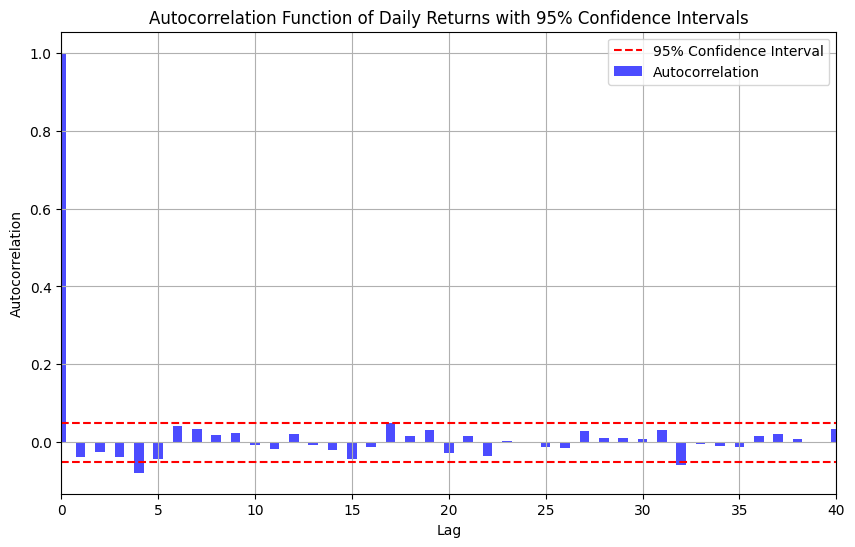

      lb_stat  lb_pvalue
20  34.761167   0.021414


In [15]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt

# Assuming 'x' is your time series data in a pandas Series
x = series_imputed # Replace with your actual time series data

# Initialize variables
solution_aic = np.inf
solution_order = (0, 0, 0)
solution_arma = None

# Search for the optimal p and q values
for i in range(1, 5):
    for j in range(1, 5):
        for k in range(1, 5):
            try:
                model = ARIMA(x, order=(i, j, k))
                model_fit = model.fit()
                actual_aic = model_fit.aic
                
                # Lower AIC is better
                if actual_aic < solution_aic:
                    solution_aic = actual_aic
                    solution_order = (i, j, k)
                    solution_arma = model_fit
            except:
                # Handle exceptions (e.g., model fitting errors)
                continue

# Print optimal AIC and order
print(f"Optimal AIC: {solution_aic}")
print(f"Optimal Order: {solution_order}")

# summary of fit model
print(model_fit.summary())

# Plot the autocorrelation function of residuals
Arima_residuals = solution_arma.resid
acf_plot(Arima_residuals,nlags = 40)

# Perform Ljung-Box test
ljung_box_test = acorr_ljungbox(Arima_residuals, lags=[20], return_df=True)
print(ljung_box_test)

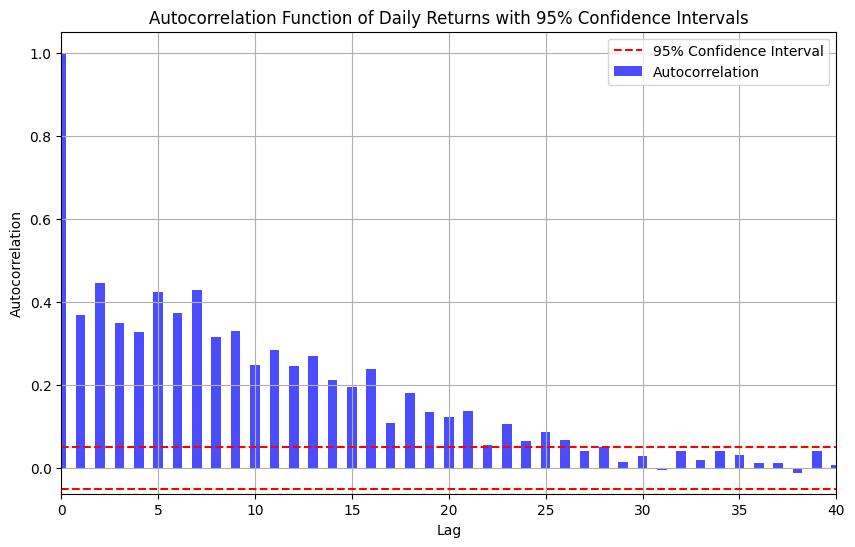

In [16]:
acf_plot(np.array(Arima_residuals) ** 2,nlags = 40)

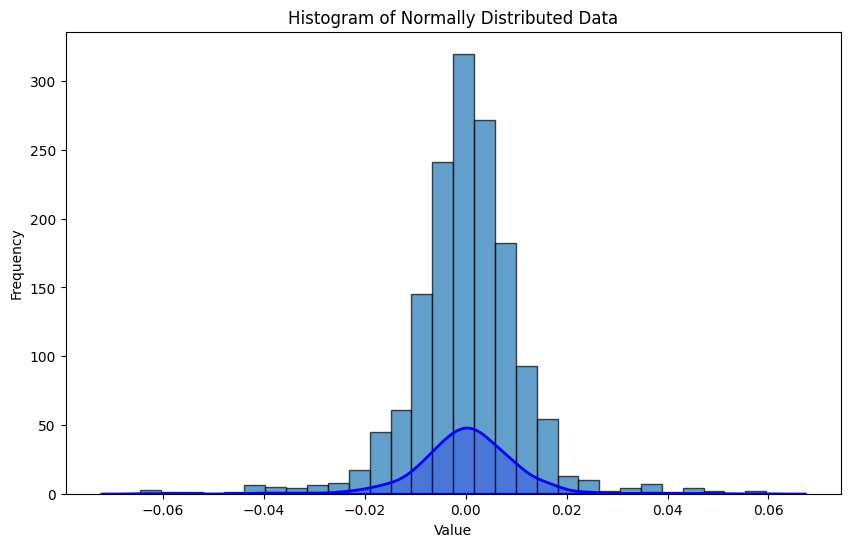

In [17]:
# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(Arima_residuals, bins=30, edgecolor='black', alpha=0.7)
# Use Seaborn to create a density plot
sns.kdeplot(Arima_residuals, fill=True, color='blue', linewidth=2)

# Add titles and labels
plt.title('Histogram of Normally Distributed Data')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
C:\Program Files\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


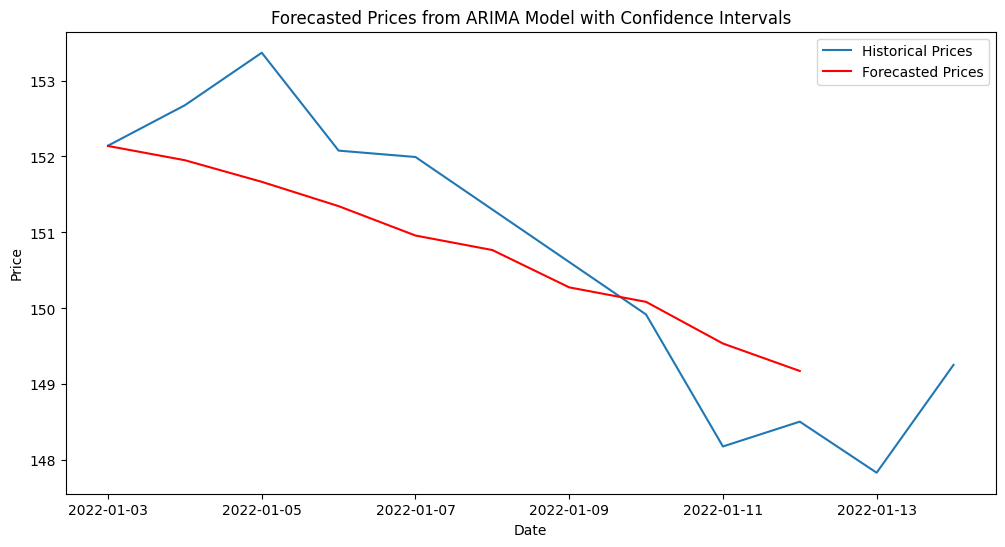

In [18]:
# Download historical data
PG = yf.download('PG', start='2016-01-01', end='2022-01-01')
PG_test = yf.download('PG', start='2022-01-01', end='2022-01-15')

# Assume last price
last_price = PG['Adj Close'][-1]  # Last known price

# Forecast future returns
forecast_steps = len(PG_test.index)  # Number of periods to forecast
forecast = model_fit.get_forecast(steps=forecast_steps)
forecasted_returns = np.array(forecast.predicted_mean)
conf_int = forecast.conf_int()

# Convert forecasted returns to prices
forecast_prices = np.zeros(forecast_steps)
forecast_prices[0] = last_price * (1 + forecasted_returns[0])

# Calculate forecasted prices
for i in range(1, forecast_steps):
    forecast_prices[i] = forecast_prices[i - 1] * (1 + forecasted_returns[i])

# Lower bound price
Lower_returns = np.array(conf_int.iloc[:, 0])
Lower_prices = np.zeros(forecast_steps)
Lower_prices[0] = last_price * (1 + Lower_returns[0])

# Calculate lower bound prices
for i in range(1, forecast_steps):
    Lower_prices[i] = Lower_prices[i - 1] * (1 + Lower_returns[i])

# Upper bound price
Upper_returns = np.array(conf_int.iloc[:, 1])
Upper_prices = np.zeros(forecast_steps)
Upper_prices[0] = last_price * (1 + Upper_returns[0])

# Calculate upper bound prices
for i in range(1, forecast_steps):
    Upper_prices[i] = Upper_prices[i - 1] * (1 + Upper_returns[i])

# Create a date range for the forecast period
forecast_dates = pd.date_range(start=PG_test.index[0], periods=forecast_steps)

# Plot the results with confidence intervals
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(PG_test.index, PG_test['Adj Close'], label='Historical Prices')

# Plot forecasted prices
plt.plot(forecast_dates, forecast_prices, label='Forecasted Prices', color='red')

# Plot confidence intervals
#plt.fill_between(forecast_dates,Lower_prices, Upper_prices, color='red', alpha=0.3, label='95% Confidence Interval')

plt.title('Forecasted Prices from ARIMA Model with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# GARCH model for volatility prediction

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4.866085717640327e+18
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3.1705310432384664e+26
Iteration:      3,   Func. Count:     34,   Neg. LLF: 80743079111478.17
Iteration:      4,   Func. Count:     49,   Neg. LLF: 2.197841784871633e+26
Iteration:      5,   Func. Count:     64,   Neg. LLF: 195896020916621.25
Iteration:      6,   Func. Count:     79,   Neg. LLF: 1.0222272634887628e+24
Iteration:      7,   Func. Count:     94,   Neg. LLF: 157573596796807.94
Iteration:      8,   Func. Count:    109,   Neg. LLF: 8.925541299733333e+18
Iteration:      9,   Func. Count:    122,   Neg. LLF: 4010.1455111918613
Iteration:     10,   Func. Count:    131,   Neg. LLF: 1981520884435438.5
Iteration:     11,   Func. Count:    144,   Neg. LLF: -4839.564939293124
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4839.56494428666
            Iterations: 15
            Function evaluations: 144
        

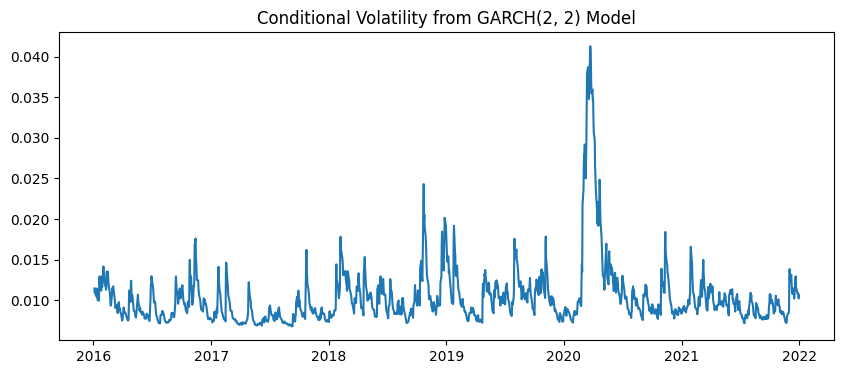

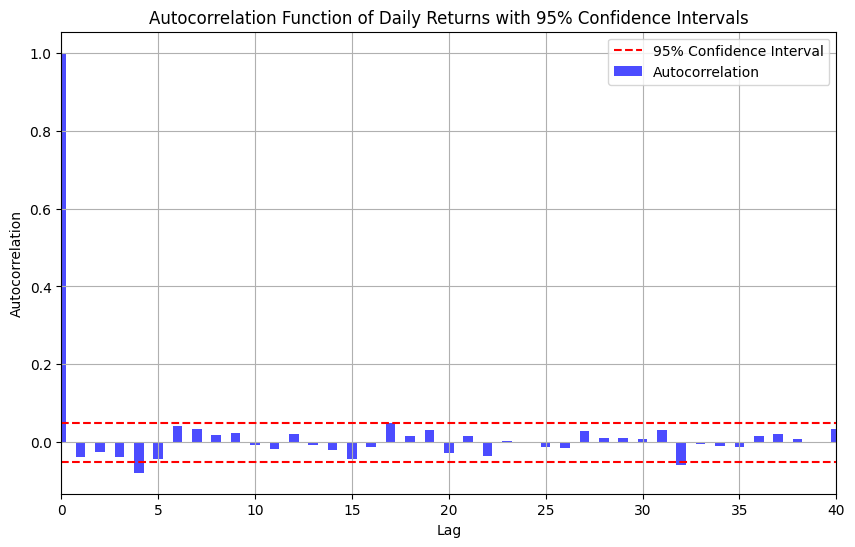

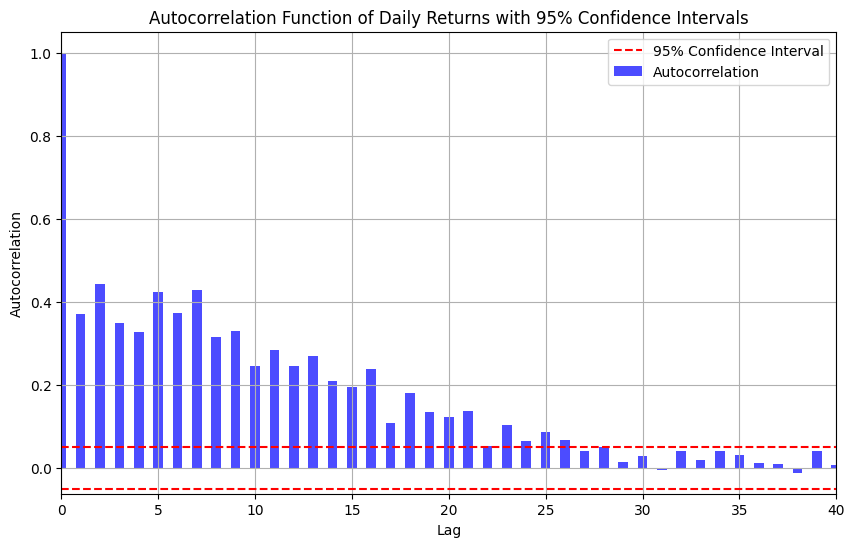

In [19]:
import numpy as np
import pandas as pd
from arch import arch_model

# Generate synthetic returns data (replace with your actual data)
returns = Arima_residuals

# Define range for p and q
p_values = range(1, 4)
q_values = range(1, 4)

# Initialize variables to track the best model
best_aic = np.inf
best_p = None
best_q = None
best_model_fit = None

# Loop over combinations of p and q
for p in p_values:
    for q in q_values:
        try:
            # Fit the GARCH(p, q) model
            model = arch_model(returns, vol='Garch', p=p, q=q)
            model_fit = model.fit()

            # Get AIC
            aic = model_fit.aic

            # Update best model if this one is better
            if aic < best_aic:
                best_aic = aic
                best_p = p
                best_q = q
                best_model_fit = model_fit

        except Exception as e:
            print(f"Error fitting GARCH({p}, {q}): {e}")

# Output the best model
print(f"Best GARCH Model: GARCH({best_p}, {best_q})")
print(f"Best AIC: {best_aic}")
print(best_model_fit.summary())

# Extract conditional volatility (standard deviation)
conditional_volatility = best_model_fit.conditional_volatility

# Plot conditional volatility
plt.figure(figsize=(10, 4))
plt.plot(conditional_volatility)
plt.title(f'Conditional Volatility from GARCH({best_p}, {best_q}) Model')
plt.show()

# Extract residuals
GARCH_residuals = best_model_fit.resid
acf_plot(GARCH_residuals,nlags = 40)
acf_plot(np.array(GARCH_residuals) ** 2,nlags = 40)

# Try GARCH(2,0) = ARCH(2)

In [20]:
model = arch_model(Arima_residuals, p=2, q=0)
model_fit = model.fit()
model_fit.summary()

rolling_predictions = []
test_size = 365

for i in range(test_size):
    train = Arima_residuals[:-(test_size-i)]
    model = arch_model(train, p=3, q=0)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

Iteration:      1,   Func. Count:      6,   Neg. LLF: 17352743494.701687
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4280852.139485695
Iteration:      3,   Func. Count:     32,   Neg. LLF: 10611282794.486923
Iteration:      4,   Func. Count:     46,   Neg. LLF: 10.249149880490762
Iteration:      5,   Func. Count:     55,   Neg. LLF: 7977409229.348854
Iteration:      6,   Func. Count:     67,   Neg. LLF: -4763.076176729876
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4763.076170844375
            Iterations: 10
            Function evaluations: 67
            Gradient evaluations: 6


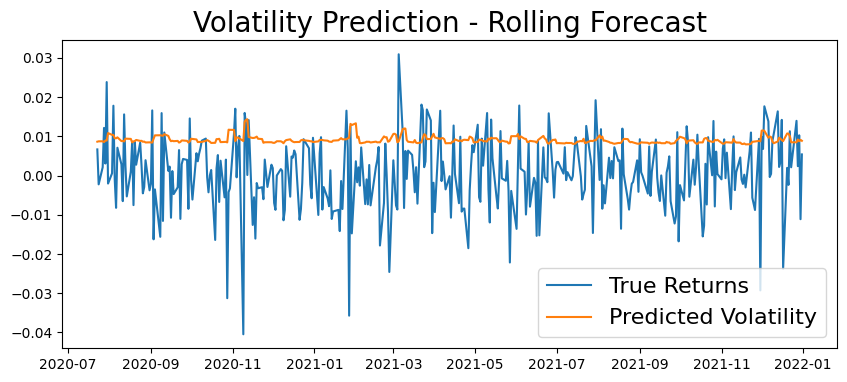

In [21]:
rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-365:])

plt.figure(figsize=(10,4))
true, = plt.plot(Arima_residuals[-365:])
preds, = plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)

# How to use the model

[*********************100%%**********************]  1 of 1 completed


Text(0.5, 1.0, 'Volatility Prediction - Next 7 Days')

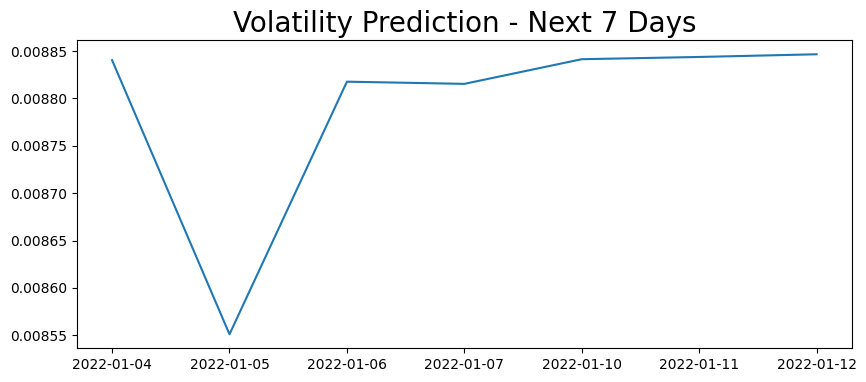

In [22]:
PG_test = yf.download('PG', start='2022-01-01', end='2022-01-15')
train = Arima_residuals
model = arch_model(train, p=2, q = 0)
model_fit = model.fit(disp='off')

pred = model_fit.forecast(horizon=7)
future_dates = [np.array(PG_test.index)[i] for i in range(1,8)]
# Convert to string with the desired format
future_dates = [date.astype('datetime64[D]').astype(str) for date in future_dates]
pred = pd.Series(np.sqrt(pred.variance.values[-1,:]), index=future_dates)

plt.figure(figsize=(10,4))
plt.plot(pred)
plt.title('Volatility Prediction - Next 7 Days', fontsize=20)